# TRAINING RESNET50 FOR MULTI-LABEL CLASSIFICATION


#### Connecting to drive

In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Adding your absolute path of your project folder to system path
import sys
sys.path.append("/content/drive/My Drive/CS 553/Project/Data/Multi_Label_dataset")

In [ ]:
%cd "/content/drive/My Drive/CS 553/Project/Data/Multi_Label_dataset"

/content/drive/My Drive/CS 553/Project/Data/Multi_Label_dataset


In [ ]:
# Checking status of gpu available through google collab
!nvidia-smi

Thu Dec  5 18:02:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#### Loading Data and Spliting in Train,Validation and Test

In [ ]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

class ImageDataset(Dataset):
    def __init__(self, csv, train, test):
        self.csv = csv
        self.train = train
        self.test = test
        #Image id from csv file
        self.all_image_names = self.csv[:]['Id']
        #labels from train csv file
        self.all_labels = np.array(self.csv.drop(['Id', 'Genre'], axis=1))
        #Train-Validation data split (85% train and 15% validation)
        self.train_ratio = int(0.85 * len(self.csv))
        self.valid_ratio = len(self.csv) - self.train_ratio
        #set the training data images and labels
        if self.train == True:
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[:self.train_ratio])
            self.labels = list(self.all_labels[:self.train_ratio])
            # define the training transforms - data augmentation
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=45),
                transforms.ToTensor(),
                transforms.Normalize(            # Normalize the tensor
                          mean=[0.5, 0.5, 0.5],  # Using ImageNet mean and std
                          std=[0.5, 0.5, 0.5]
                          )
            ])
        # set the validation data images and labels
        elif self.train == False and self.test == False:
            print(f"Number of validation images: {self.valid_ratio}")
            self.image_names = list(self.all_image_names[-self.valid_ratio:-10])
            self.labels = list(self.all_labels[-self.valid_ratio:-10])
            # define the validation transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ])
        # set the test data images and label (last 10 images)
        elif self.test == True and self.train == False:
            self.image_names = list(self.all_image_names[-10:])
            self.labels = list(self.all_labels[-10:])
             # define the test transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
            ])
    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        image = cv2.imread(f"Images/{self.image_names[index]}.jpg")
        # convert the image from BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply image transforms
        image = self.transform(image)
        targets = self.labels[index]

        return {
            'image':image.clone().detach() if isinstance(image, torch.Tensor) else torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32)
        }

#### Evaluation Metrics

In [ ]:
from sklearn.metrics import average_precision_score,roc_auc_score
def compute_mAP(outputs,labels):
    y_true = labels.cpu().detach().numpy()
    y_pred = outputs.cpu().detach().numpy()
    AP = []
    for i in range(y_true.shape[0]):
        AP.append(average_precision_score(y_true[i],y_pred[i]))
    return np.mean(AP)

def comput_roc(outputs,labels):
    y_true = labels.cpu().detach().numpy()
    y_pred = outputs.cpu().detach().numpy()
    ROC = []
    for i in range(y_true.shape[0]):
        ROC.append(roc_auc_score(y_true[i],y_pred[i]))
    return np.mean(ROC)

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score
def calculate_metrics(pred, target, threshold=0.5):
    pred = np.array(pred > threshold, dtype=float)
    return {'micro/precision': precision_score(y_true=target, y_pred=pred, average='micro'),
            'micro/recall': recall_score(y_true=target, y_pred=pred, average='micro'),
            'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro',zero_division=0),
            'macro/precision': precision_score(y_true=target, y_pred=pred, average='macro'),
            'macro/recall': recall_score(y_true=target, y_pred=pred, average='macro'),
            'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro',zero_division=0),
            'samples/precision': precision_score(y_true=target, y_pred=pred, average='samples'),
            'samples/recall': recall_score(y_true=target, y_pred=pred, average='samples'),
            'samples/f1': f1_score(y_true=target, y_pred=pred, average='samples',zero_division=0)
            }

#### Creating Train Function

In [ ]:
from tqdm import tqdm
# training function
def train(model, dataloader, optimizer, criterion, train_data, device):
    print('Training')
    model.train()
    counter = 0
    train_running_loss = 0.0
    train_running_mAP = 0.0
    train_running_ROC = 0.0
    train_running_mAP = 0.0
    train_running_ROC = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        counter += 1
        data, target = data['image'].to(device), data['label'].to(device)
        #setting gradients to zero
        optimizer.zero_grad()
        #forward pass
        outputs = model(data)
        # apply sigmoid activation to get all the outputs between 0 and 1
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        train_running_mAP += compute_mAP(outputs,target)
        train_running_ROC += comput_roc(outputs,target)
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()

    train_loss = train_running_loss / counter
    train_mAP = train_running_mAP/counter
    train_ROC = train_running_ROC/counter
    print(f"Train mAP: {train_mAP:.4f}")
    print(f'Train ROC: {train_ROC:.4f}')
    return train_loss,train_mAP,train_ROC


#### Creating Validation Function

In [ ]:
def validate(model, dataloader, criterion, val_data, device):
    print('Validating')
    model.eval()
    counter = 0
    val_running_loss = 0.0
    val_running_mAP = 0.0
    val_running_ROC = 0.0
    with torch.no_grad():
        model_result = []
        targets = []
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            counter += 1
            data, target = data['image'].to(device), data['label'].to(device)
            outputs = model(data)
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, target)
            model_result.extend(outputs.cpu().numpy())
            targets.extend(target.cpu().numpy())
            val_running_mAP += compute_mAP(outputs,target)
            val_running_ROC += comput_roc(outputs,target)
            val_running_loss += loss.item()
        result = calculate_metrics(np.array(model_result), np.array(targets))
        val_loss = val_running_loss / counter
        val_mAP = val_running_mAP/counter
        val_ROC = val_running_ROC/counter
        print("epoch:{:2d}  test: "
                  "micro f1: {:.3f} "
                  "macro f1: {:.3f} "
                  "samples f1: {:.3f}".format(epoch,
                                              result['micro/f1'],
                                              result['macro/f1'],
                                              result['samples/f1']))
        print(f"Val mAP: {val_mAP:.4f}")
        print(f'Val ROC: {val_ROC:.4f}')
        return val_loss,val_mAP,val_ROC

#ResNet MODEL

In [ ]:
from torchvision import models as models
import torch.nn as nn
def create_model(pretrained, requires_grad):
    model = models.resnet50(progress=True)
    # to freeze the hidden layers
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    # to train the hidden layers
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    # make the classification layer learnable
    # we have 25 classes in total
    model.fc = nn.Linear(2048, 25)
    return model

#TRAINING

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
matplotlib.style.use('ggplot')
# initialize the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#intialize the model
# Create a ResNet50 model with frozen layers
model = create_model(pretrained=True, requires_grad=False).to(device)

In [ ]:
############ Traning for 4 epochs ############
#parameters
lr = 0.0001
epochs = 4
batch_size = 256
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()

# read the training csv file
train_csv = pd.read_csv('train.csv')

# train dataset
train_data = ImageDataset(
    train_csv, train=True, test=False
)
# validation dataset
valid_data = ImageDataset(
    train_csv, train=False, test=False
)
# train data loader
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)
# validation data loader
valid_loader = DataLoader(
    valid_data,
    batch_size=batch_size,
    shuffle=False
)



Number of training images: 6165
Number of validation images: 1089


In [ ]:
!pip install torchinfo

In [ ]:
import torchinfo
from torchinfo import summary


# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(batch_size, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size"], # uncomment for smaller output
        #col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape
ResNet (ResNet)                          [256, 3, 400, 400]
├─Conv2d (conv1)                         [256, 3, 400, 400]
├─BatchNorm2d (bn1)                      [256, 64, 200, 200]
├─ReLU (relu)                            [256, 64, 200, 200]
├─MaxPool2d (maxpool)                    [256, 64, 200, 200]
├─Sequential (layer1)                    [256, 64, 100, 100]
│    └─Bottleneck (0)                    [256, 64, 100, 100]
│    │    └─Conv2d (conv1)               [256, 64, 100, 100]
│    │    └─BatchNorm2d (bn1)            [256, 64, 100, 100]
│    │    └─ReLU (relu)                  [256, 64, 100, 100]
│    │    └─Conv2d (conv2)               [256, 64, 100, 100]
│    │    └─BatchNorm2d (bn2)            [256, 64, 100, 100]
│    │    └─ReLU (relu)                  [256, 64, 100, 100]
│    │    └─Conv2d (conv3)               [256, 64, 100, 100]
│    │    └─BatchNorm2d (bn3)            [256, 256, 100, 100]
│    │    └─Sequential (downsampl

##### Training Run 1 - 4 epochs

In [ ]:
train_loss = []
valid_loss = []
train_mAP = []
train_ROC = []
valid_mAP = []
valid_ROC = []
for epoch in range(epochs):
    model.to(device)
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss,train_epoch_mAP,train_epoch_ROC = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss,val_epoch_mAP,val_epoch_ROC = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_mAP.append(train_epoch_mAP)
    train_ROC.append(train_epoch_ROC)
    valid_mAP.append(val_epoch_mAP)
    valid_ROC.append(val_epoch_ROC)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

Epoch 1 of 4
Training


25it [1:24:21, 202.45s/it]


Train mAP: 0.4165
Train ROC: 0.6848
Validating


5it [14:53, 178.71s/it]


epoch: 0  test: micro f1: 0.282 macro f1: 0.025 samples f1: 0.288
Val mAP: 0.4905
Val ROC: 0.7846
Train Loss: 0.3811
Val Loss: 0.3132
Epoch 2 of 4
Training


25it [01:31,  3.65s/it]


Train mAP: 0.5514
Train ROC: 0.8260
Validating


5it [00:15,  3.02s/it]


epoch: 1  test: micro f1: 0.282 macro f1: 0.025 samples f1: 0.288
Val mAP: 0.4948
Val ROC: 0.7964
Train Loss: 0.2544
Val Loss: 0.2629
Epoch 3 of 4
Training


25it [01:32,  3.69s/it]


Train mAP: 0.5564
Train ROC: 0.8330
Validating


5it [00:14,  2.98s/it]


epoch: 2  test: micro f1: 0.280 macro f1: 0.025 samples f1: 0.285
Val mAP: 0.4974
Val ROC: 0.8025
Train Loss: 0.2486
Val Loss: 0.2563
Epoch 4 of 4
Training


25it [01:30,  3.63s/it]


Train mAP: 0.5544
Train ROC: 0.8371
Validating


5it [00:15,  3.06s/it]

epoch: 3  test: micro f1: 0.251 macro f1: 0.024 samples f1: 0.241
Val mAP: 0.4974
Val ROC: 0.8039
Train Loss: 0.2468
Val Loss: 0.2535


In [ ]:
for epoch in range(epochs):
    model.to(device)
    print(f"Epoch {epoch+1+4} of {epochs+4}")
    train_epoch_loss,train_epoch_mAP,train_epoch_ROC = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss,val_epoch_mAP,val_epoch_ROC = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_mAP.append(train_epoch_mAP)
    train_ROC.append(train_epoch_ROC)
    valid_mAP.append(val_epoch_mAP)
    valid_ROC.append(val_epoch_ROC)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

Epoch 5 of 8
Training


25it [01:56,  4.67s/it]


Train mAP: 0.5607
Train ROC: 0.8397
Validating


5it [00:15,  3.01s/it]


epoch: 0  test: micro f1: 0.282 macro f1: 0.025 samples f1: 0.288
Val mAP: 0.4958
Val ROC: 0.8022
Train Loss: 0.2445
Val Loss: 0.2531
Epoch 6 of 8
Training


25it [01:32,  3.70s/it]


Train mAP: 0.5619
Train ROC: 0.8380
Validating


5it [00:15,  3.13s/it]


epoch: 1  test: micro f1: 0.282 macro f1: 0.025 samples f1: 0.288
Val mAP: 0.4972
Val ROC: 0.8025
Train Loss: 0.2445
Val Loss: 0.2528
Epoch 7 of 8
Training


25it [01:32,  3.71s/it]


Train mAP: 0.5557
Train ROC: 0.8365
Validating


5it [00:15,  3.04s/it]


epoch: 2  test: micro f1: 0.276 macro f1: 0.025 samples f1: 0.278
Val mAP: 0.4952
Val ROC: 0.7985
Train Loss: 0.2454
Val Loss: 0.2525
Epoch 8 of 8
Training


25it [01:33,  3.75s/it]


Train mAP: 0.5590
Train ROC: 0.8396
Validating


5it [00:15,  3.09s/it]

epoch: 3  test: micro f1: 0.282 macro f1: 0.025 samples f1: 0.287
Val mAP: 0.4952
Val ROC: 0.7982
Train Loss: 0.2435
Val Loss: 0.2526


In [ ]:
for epoch in range(2):
    model.to(device)
    print(f"Epoch {epoch+1+8} of {2+8}")
    train_epoch_loss,train_epoch_mAP,train_epoch_ROC = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss,val_epoch_mAP,val_epoch_ROC = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_mAP.append(train_epoch_mAP)
    train_ROC.append(train_epoch_ROC)
    valid_mAP.append(val_epoch_mAP)
    valid_ROC.append(val_epoch_ROC)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

Epoch 9 of 10
Training


25it [01:41,  4.04s/it]


Train mAP: 0.5648
Train ROC: 0.8421
Validating


5it [00:15,  3.17s/it]


epoch: 0  test: micro f1: 0.281 macro f1: 0.025 samples f1: 0.286
Val mAP: 0.4945
Val ROC: 0.7944
Train Loss: 0.2408
Val Loss: 0.2527
Epoch 10 of 10
Training


25it [01:33,  3.74s/it]


Train mAP: 0.5610
Train ROC: 0.8383
Validating


5it [00:15,  3.04s/it]

epoch: 1  test: micro f1: 0.282 macro f1: 0.025 samples f1: 0.288
Val mAP: 0.4940
Val ROC: 0.7911
Train Loss: 0.2423
Val Loss: 0.2529


In [ ]:
torch.save({
     'epoch': epochs,
     'model_state_dict': model.state_dict(),
     'optimizer_state_dict': optimizer.state_dict(),
     'loss': criterion,
     'train_loss': train_loss,
     'valid_loss': valid_loss,
     'train_mAP': train_mAP,
     'train_ROC': train_ROC,
     'valid_mAP': valid_mAP,
     'valid_ROC': valid_ROC
                 }, 'model_rerun.pth')

#### Reoading and Training saved model

In [ ]:
# Load the checkpoint
checkpoint = torch.load('model2.pth')

<ipython-input-15-072f477afb07>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model2.pth')


In [ ]:
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch
loss = checkpoint['loss']

In [ ]:
epochs

4

In [ ]:
total_epochs = start_epoch + epochs
total_epochs

50

In [ ]:
train_loss = []
valid_loss = []
train_mAP = []
train_ROC = []
valid_mAP = []
valid_ROC = []
for epoch in range(start_epoch, total_epochs):
    model.to(device)
    print(f"Epoch {epoch+1} of {total_epochs}")
    train_epoch_loss,train_epoch_mAP,train_epoch_ROC = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss,val_epoch_mAP,val_epoch_ROC = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_mAP.append(train_epoch_mAP)
    train_ROC.append(train_epoch_ROC)
    valid_mAP.append(val_epoch_mAP)
    valid_ROC.append(val_epoch_ROC)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

Epoch 46 of 50
Training


25it [37:08, 89.14s/it]


Train mAP: 0.5673
Train ROC: 0.8409
Validating


5it [06:33, 78.77s/it]


epoch:45  test: micro f1: 0.292 macro f1: 0.037 samples f1: 0.290
Val mAP: 0.4633
Val ROC: 0.7636
Train Loss: 0.2402
Val Loss: 0.2724
Epoch 47 of 50
Training


25it [01:31,  3.67s/it]


Train mAP: 0.5688
Train ROC: 0.8386
Validating


5it [00:15,  3.18s/it]


epoch:46  test: micro f1: 0.282 macro f1: 0.025 samples f1: 0.288
Val mAP: 0.4784
Val ROC: 0.7735
Train Loss: 0.2396
Val Loss: 0.2623
Epoch 48 of 50
Training


25it [01:32,  3.69s/it]


Train mAP: 0.5681
Train ROC: 0.8371
Validating


5it [00:15,  3.08s/it]


epoch:47  test: micro f1: 0.304 macro f1: 0.035 samples f1: 0.306
Val mAP: 0.4822
Val ROC: 0.7668
Train Loss: 0.2405
Val Loss: 0.2599
Epoch 49 of 50
Training


25it [01:31,  3.67s/it]


Train mAP: 0.5749
Train ROC: 0.8432
Validating


5it [00:15,  3.05s/it]


epoch:48  test: micro f1: 0.294 macro f1: 0.031 samples f1: 0.297
Val mAP: 0.4889
Val ROC: 0.7888
Train Loss: 0.2370
Val Loss: 0.2585
Epoch 50 of 50
Training


25it [01:32,  3.69s/it]


Train mAP: 0.5744
Train ROC: 0.8417
Validating


5it [00:15,  3.05s/it]

epoch:49  test: micro f1: 0.324 macro f1: 0.042 samples f1: 0.316
Val mAP: 0.4870
Val ROC: 0.7859
Train Loss: 0.2381
Val Loss: 0.2547


In [ ]:
start_epoch=50
epochs = 20
total_epochs = start_epoch + epochs
total_epochs

70

In [ ]:
for epoch in range(start_epoch, total_epochs):
    model.to(device)
    print(f"Epoch {epoch+1} of {total_epochs}")
    train_epoch_loss,train_epoch_mAP,train_epoch_ROC = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss,val_epoch_mAP,val_epoch_ROC = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_mAP.append(train_epoch_mAP)
    train_ROC.append(train_epoch_ROC)
    valid_mAP.append(val_epoch_mAP)
    valid_ROC.append(val_epoch_ROC)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

Epoch 51 of 70
Training


25it [01:32,  3.72s/it]


Train mAP: 0.5632
Train ROC: 0.8391
Validating


5it [00:16,  3.30s/it]


epoch:50  test: micro f1: 0.288 macro f1: 0.029 samples f1: 0.292
Val mAP: 0.4825
Val ROC: 0.7740
Train Loss: 0.2410
Val Loss: 0.2610
Epoch 52 of 70
Training


25it [01:34,  3.80s/it]


Train mAP: 0.5670
Train ROC: 0.8396
Validating


5it [00:15,  3.10s/it]


epoch:51  test: micro f1: 0.290 macro f1: 0.029 samples f1: 0.295
Val mAP: 0.4899
Val ROC: 0.7973
Train Loss: 0.2398
Val Loss: 0.2545
Epoch 53 of 70
Training


25it [01:33,  3.72s/it]


Train mAP: 0.5732
Train ROC: 0.8395
Validating


5it [00:15,  3.06s/it]


epoch:52  test: micro f1: 0.298 macro f1: 0.033 samples f1: 0.298
Val mAP: 0.4895
Val ROC: 0.7772
Train Loss: 0.2374
Val Loss: 0.2593
Epoch 54 of 70
Training


25it [01:31,  3.65s/it]


Train mAP: 0.5643
Train ROC: 0.8354
Validating


5it [00:15,  3.13s/it]


epoch:53  test: micro f1: 0.272 macro f1: 0.026 samples f1: 0.272
Val mAP: 0.4808
Val ROC: 0.7714
Train Loss: 0.2418
Val Loss: 0.2581
Epoch 55 of 70
Training


25it [01:33,  3.74s/it]


Train mAP: 0.5757
Train ROC: 0.8448
Validating


5it [00:15,  3.11s/it]


epoch:54  test: micro f1: 0.307 macro f1: 0.037 samples f1: 0.308
Val mAP: 0.4762
Val ROC: 0.7693
Train Loss: 0.2370
Val Loss: 0.2713
Epoch 56 of 70
Training


25it [01:33,  3.74s/it]


Train mAP: 0.5780
Train ROC: 0.8444
Validating


5it [00:15,  3.07s/it]


epoch:55  test: micro f1: 0.293 macro f1: 0.033 samples f1: 0.296
Val mAP: 0.4798
Val ROC: 0.7938
Train Loss: 0.2365
Val Loss: 0.2580
Epoch 57 of 70
Training


25it [01:33,  3.74s/it]


Train mAP: 0.5759
Train ROC: 0.8442
Validating


5it [00:16,  3.29s/it]


epoch:56  test: micro f1: 0.286 macro f1: 0.028 samples f1: 0.291
Val mAP: 0.4697
Val ROC: 0.7856
Train Loss: 0.2370
Val Loss: 0.2614
Epoch 58 of 70
Training


25it [01:33,  3.73s/it]


Train mAP: 0.5755
Train ROC: 0.8444
Validating


5it [00:15,  3.06s/it]


epoch:57  test: micro f1: 0.283 macro f1: 0.026 samples f1: 0.289
Val mAP: 0.4707
Val ROC: 0.7772
Train Loss: 0.2364
Val Loss: 0.2648
Epoch 59 of 70
Training


25it [01:32,  3.69s/it]


Train mAP: 0.5752
Train ROC: 0.8458
Validating


5it [00:15,  3.11s/it]


epoch:58  test: micro f1: 0.283 macro f1: 0.026 samples f1: 0.289
Val mAP: 0.4702
Val ROC: 0.7908
Train Loss: 0.2376
Val Loss: 0.2587
Epoch 60 of 70
Training


25it [01:33,  3.73s/it]


Train mAP: 0.5757
Train ROC: 0.8416
Validating


5it [00:15,  3.02s/it]


epoch:59  test: micro f1: 0.283 macro f1: 0.025 samples f1: 0.289
Val mAP: 0.4667
Val ROC: 0.7738
Train Loss: 0.2377
Val Loss: 0.2647
Epoch 61 of 70
Training


25it [01:32,  3.71s/it]


Train mAP: 0.5675
Train ROC: 0.8401
Validating


5it [00:15,  3.04s/it]


epoch:60  test: micro f1: 0.286 macro f1: 0.032 samples f1: 0.287
Val mAP: 0.4603
Val ROC: 0.7795
Train Loss: 0.2408
Val Loss: 0.2630
Epoch 62 of 70
Training


25it [01:32,  3.69s/it]


Train mAP: 0.5629
Train ROC: 0.8394
Validating


5it [00:15,  3.12s/it]


epoch:61  test: micro f1: 0.282 macro f1: 0.026 samples f1: 0.286
Val mAP: 0.4833
Val ROC: 0.7878
Train Loss: 0.2413
Val Loss: 0.2559
Epoch 63 of 70
Training


25it [01:32,  3.68s/it]


Train mAP: 0.5687
Train ROC: 0.8392
Validating


5it [00:15,  3.10s/it]


epoch:62  test: micro f1: 0.282 macro f1: 0.025 samples f1: 0.288
Val mAP: 0.4655
Val ROC: 0.7651
Train Loss: 0.2394
Val Loss: 0.2708
Epoch 64 of 70
Training


25it [01:31,  3.65s/it]


Train mAP: 0.5714
Train ROC: 0.8401
Validating


5it [00:15,  3.05s/it]


epoch:63  test: micro f1: 0.293 macro f1: 0.030 samples f1: 0.296
Val mAP: 0.4862
Val ROC: 0.7894
Train Loss: 0.2386
Val Loss: 0.2593
Epoch 65 of 70
Training


25it [01:33,  3.73s/it]


Train mAP: 0.5723
Train ROC: 0.8427
Validating


5it [00:15,  3.04s/it]


epoch:64  test: micro f1: 0.303 macro f1: 0.041 samples f1: 0.298
Val mAP: 0.4736
Val ROC: 0.7857
Train Loss: 0.2385
Val Loss: 0.2608
Epoch 66 of 70
Training


25it [01:31,  3.68s/it]


Train mAP: 0.5756
Train ROC: 0.8423
Validating


5it [00:15,  3.07s/it]


epoch:65  test: micro f1: 0.288 macro f1: 0.028 samples f1: 0.293
Val mAP: 0.4906
Val ROC: 0.8029
Train Loss: 0.2367
Val Loss: 0.2586
Epoch 67 of 70
Training


25it [01:31,  3.66s/it]


Train mAP: 0.5761
Train ROC: 0.8447
Validating


5it [00:15,  3.05s/it]


epoch:66  test: micro f1: 0.287 macro f1: 0.030 samples f1: 0.291
Val mAP: 0.4739
Val ROC: 0.7882
Train Loss: 0.2362
Val Loss: 0.2636
Epoch 68 of 70
Training


25it [01:32,  3.69s/it]


Train mAP: 0.5819
Train ROC: 0.8468
Validating


5it [00:15,  3.04s/it]


epoch:67  test: micro f1: 0.283 macro f1: 0.026 samples f1: 0.289
Val mAP: 0.4818
Val ROC: 0.7687
Train Loss: 0.2353
Val Loss: 0.2661
Epoch 69 of 70
Training


25it [01:31,  3.66s/it]


Train mAP: 0.5743
Train ROC: 0.8418
Validating


5it [00:15,  3.01s/it]


epoch:68  test: micro f1: 0.284 macro f1: 0.026 samples f1: 0.289
Val mAP: 0.4777
Val ROC: 0.7761
Train Loss: 0.2380
Val Loss: 0.2623
Epoch 70 of 70
Training


25it [01:31,  3.68s/it]


Train mAP: 0.5752
Train ROC: 0.8434
Validating


5it [00:15,  3.09s/it]

epoch:69  test: micro f1: 0.298 macro f1: 0.035 samples f1: 0.295
Val mAP: 0.4798
Val ROC: 0.7744
Train Loss: 0.2376
Val Loss: 0.2587


In [ ]:
start_epoch=70
epochs = 20
total_epochs = start_epoch + epochs
total_epochs

90

In [ ]:
for epoch in range(start_epoch, total_epochs):
    model.to(device)
    print(f"Epoch {epoch+1} of {total_epochs}")
    train_epoch_loss,train_epoch_mAP,train_epoch_ROC = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss,val_epoch_mAP,val_epoch_ROC = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_mAP.append(train_epoch_mAP)
    train_ROC.append(train_epoch_ROC)
    valid_mAP.append(val_epoch_mAP)
    valid_ROC.append(val_epoch_ROC)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

Epoch 71 of 90
Training


25it [01:30,  3.62s/it]


Train mAP: 0.5729
Train ROC: 0.8437
Validating


5it [00:15,  3.17s/it]


epoch:70  test: micro f1: 0.292 macro f1: 0.030 samples f1: 0.296
Val mAP: 0.4846
Val ROC: 0.7791
Train Loss: 0.2386
Val Loss: 0.2626
Epoch 72 of 90
Training


25it [01:31,  3.66s/it]


Train mAP: 0.5620
Train ROC: 0.8369
Validating


5it [00:15,  3.09s/it]


epoch:71  test: micro f1: 0.312 macro f1: 0.039 samples f1: 0.311
Val mAP: 0.4847
Val ROC: 0.7866
Train Loss: 0.2420
Val Loss: 0.2633
Epoch 73 of 90
Training


25it [01:31,  3.66s/it]


Train mAP: 0.5722
Train ROC: 0.8413
Validating


5it [00:15,  3.03s/it]


epoch:72  test: micro f1: 0.334 macro f1: 0.043 samples f1: 0.331
Val mAP: 0.4903
Val ROC: 0.7867
Train Loss: 0.2383
Val Loss: 0.2590
Epoch 74 of 90
Training


25it [01:31,  3.67s/it]


Train mAP: 0.5780
Train ROC: 0.8427
Validating


5it [00:15,  3.12s/it]


epoch:73  test: micro f1: 0.311 macro f1: 0.038 samples f1: 0.312
Val mAP: 0.4840
Val ROC: 0.7893
Train Loss: 0.2387
Val Loss: 0.2603
Epoch 75 of 90
Training


25it [01:31,  3.67s/it]


Train mAP: 0.5795
Train ROC: 0.8446
Validating


5it [00:15,  3.04s/it]


epoch:74  test: micro f1: 0.312 macro f1: 0.039 samples f1: 0.313
Val mAP: 0.4917
Val ROC: 0.8028
Train Loss: 0.2348
Val Loss: 0.2592
Epoch 76 of 90
Training


25it [01:31,  3.67s/it]


Train mAP: 0.5732
Train ROC: 0.8469
Validating


5it [00:15,  3.09s/it]


epoch:75  test: micro f1: 0.296 macro f1: 0.032 samples f1: 0.298
Val mAP: 0.4837
Val ROC: 0.7948
Train Loss: 0.2359
Val Loss: 0.2576
Epoch 77 of 90
Training


25it [01:36,  3.85s/it]


Train mAP: 0.5753
Train ROC: 0.8431
Validating


5it [00:15,  3.07s/it]


epoch:76  test: micro f1: 0.290 macro f1: 0.029 samples f1: 0.294
Val mAP: 0.4846
Val ROC: 0.7862
Train Loss: 0.2377
Val Loss: 0.2574
Epoch 78 of 90
Training


25it [01:32,  3.71s/it]


Train mAP: 0.5794
Train ROC: 0.8442
Validating


5it [00:15,  3.13s/it]


epoch:77  test: micro f1: 0.338 macro f1: 0.053 samples f1: 0.327
Val mAP: 0.4662
Val ROC: 0.7581
Train Loss: 0.2360
Val Loss: 0.2757
Epoch 79 of 90
Training


25it [01:31,  3.65s/it]


Train mAP: 0.5814
Train ROC: 0.8434
Validating


5it [00:15,  3.04s/it]


epoch:78  test: micro f1: 0.323 macro f1: 0.043 samples f1: 0.320
Val mAP: 0.4901
Val ROC: 0.8021
Train Loss: 0.2353
Val Loss: 0.2672
Epoch 80 of 90
Training


25it [01:31,  3.67s/it]


Train mAP: 0.5755
Train ROC: 0.8446
Validating


5it [00:15,  3.06s/it]


epoch:79  test: micro f1: 0.306 macro f1: 0.035 samples f1: 0.307
Val mAP: 0.4819
Val ROC: 0.7756
Train Loss: 0.2371
Val Loss: 0.2624
Epoch 81 of 90
Training


25it [01:32,  3.71s/it]


Train mAP: 0.5776
Train ROC: 0.8425
Validating


5it [00:15,  3.03s/it]


epoch:80  test: micro f1: 0.296 macro f1: 0.037 samples f1: 0.295
Val mAP: 0.4644
Val ROC: 0.7718
Train Loss: 0.2369
Val Loss: 0.2657
Epoch 82 of 90
Training


25it [01:30,  3.62s/it]


Train mAP: 0.5766
Train ROC: 0.8424
Validating


5it [00:15,  3.00s/it]


epoch:81  test: micro f1: 0.302 macro f1: 0.039 samples f1: 0.295
Val mAP: 0.4814
Val ROC: 0.7812
Train Loss: 0.2375
Val Loss: 0.2619
Epoch 83 of 90
Training


25it [01:31,  3.66s/it]


Train mAP: 0.5703
Train ROC: 0.8420
Validating


5it [00:15,  3.19s/it]


epoch:82  test: micro f1: 0.294 macro f1: 0.038 samples f1: 0.292
Val mAP: 0.4630
Val ROC: 0.7827
Train Loss: 0.2374
Val Loss: 0.2714
Epoch 84 of 90
Training


25it [01:31,  3.66s/it]


Train mAP: 0.5773
Train ROC: 0.8452
Validating


5it [00:15,  3.03s/it]


epoch:83  test: micro f1: 0.294 macro f1: 0.032 samples f1: 0.297
Val mAP: 0.4766
Val ROC: 0.7773
Train Loss: 0.2365
Val Loss: 0.2690
Epoch 85 of 90
Training


25it [01:30,  3.64s/it]


Train mAP: 0.5760
Train ROC: 0.8448
Validating


5it [00:15,  3.10s/it]


epoch:84  test: micro f1: 0.283 macro f1: 0.027 samples f1: 0.288
Val mAP: 0.4661
Val ROC: 0.7763
Train Loss: 0.2365
Val Loss: 0.2710
Epoch 86 of 90
Training


25it [01:31,  3.66s/it]


Train mAP: 0.5688
Train ROC: 0.8424
Validating


5it [00:15,  3.02s/it]


epoch:85  test: micro f1: 0.282 macro f1: 0.025 samples f1: 0.288
Val mAP: 0.4772
Val ROC: 0.7823
Train Loss: 0.2376
Val Loss: 0.2620
Epoch 87 of 90
Training


25it [01:31,  3.65s/it]


Train mAP: 0.5723
Train ROC: 0.8425
Validating


5it [00:15,  3.04s/it]


epoch:86  test: micro f1: 0.306 macro f1: 0.041 samples f1: 0.302
Val mAP: 0.4729
Val ROC: 0.7842
Train Loss: 0.2380
Val Loss: 0.2691
Epoch 88 of 90
Training


25it [01:32,  3.69s/it]


Train mAP: 0.5812
Train ROC: 0.8454
Validating


5it [00:15,  3.07s/it]


epoch:87  test: micro f1: 0.302 macro f1: 0.035 samples f1: 0.303
Val mAP: 0.4790
Val ROC: 0.7788
Train Loss: 0.2369
Val Loss: 0.2671
Epoch 89 of 90
Training


25it [01:31,  3.65s/it]


Train mAP: 0.5805
Train ROC: 0.8411
Validating


5it [00:15,  3.03s/it]


epoch:88  test: micro f1: 0.287 macro f1: 0.031 samples f1: 0.290
Val mAP: 0.4664
Val ROC: 0.7797
Train Loss: 0.2363
Val Loss: 0.2673
Epoch 90 of 90
Training


25it [01:30,  3.63s/it]


Train mAP: 0.5797
Train ROC: 0.8457
Validating


5it [00:15,  3.10s/it]

epoch:89  test: micro f1: 0.326 macro f1: 0.044 samples f1: 0.323
Val mAP: 0.4848
Val ROC: 0.7899
Train Loss: 0.2356
Val Loss: 0.2675


In [ ]:
 # save the trained model to disk
 torch.save({
     'epoch': epochs,
     'model_state_dict': model.state_dict(),
     'optimizer_state_dict': optimizer.state_dict(),
     'loss': criterion,
     'train_loss': train_loss,
     'valid_loss': valid_loss,
     'train_mAP': train_mAP,
     'train_ROC': train_ROC,
     'valid_mAP': valid_mAP,
     'valid_ROC': valid_ROC
                 }, 'model3.pth')

In [ ]:
checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # Resume from next epoch
    criterion = checkpoint['loss']  # Ensure loss function matches
    train_loss = checkpoint.get('train_loss', [])  # Initialize if stored
    valid_loss = checkpoint.get('valid_loss', [])
    train_mAP = checkpoint.get('train_mAP', [])
    train_ROC = checkpoint.get('train_ROC', [])
    valid_mAP = checkpoint.get('valid_mAP', [])
    valid_ROC = checkpoint.get('valid_ROC', [])

# PLOTTONG GRAPHS

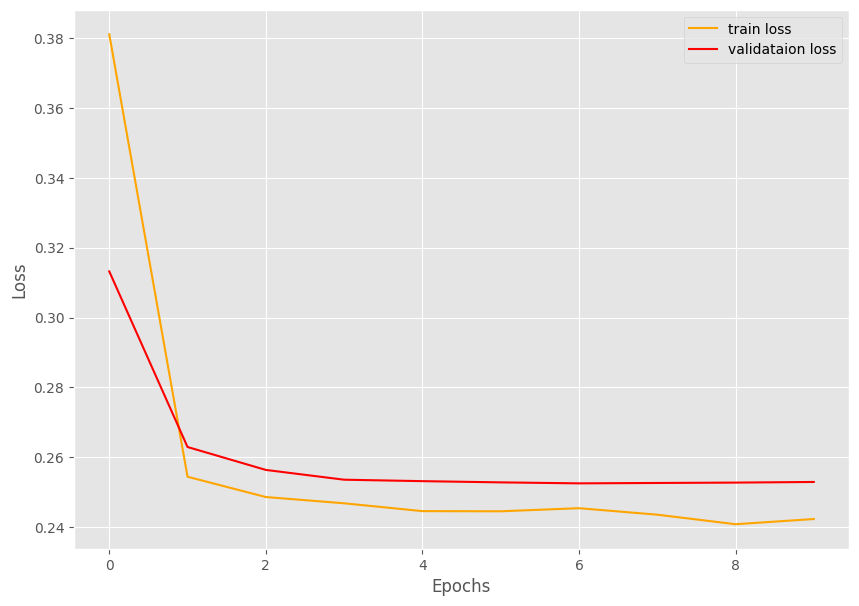

In [ ]:
# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(valid_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../loss_rerun.png')
plt.show()

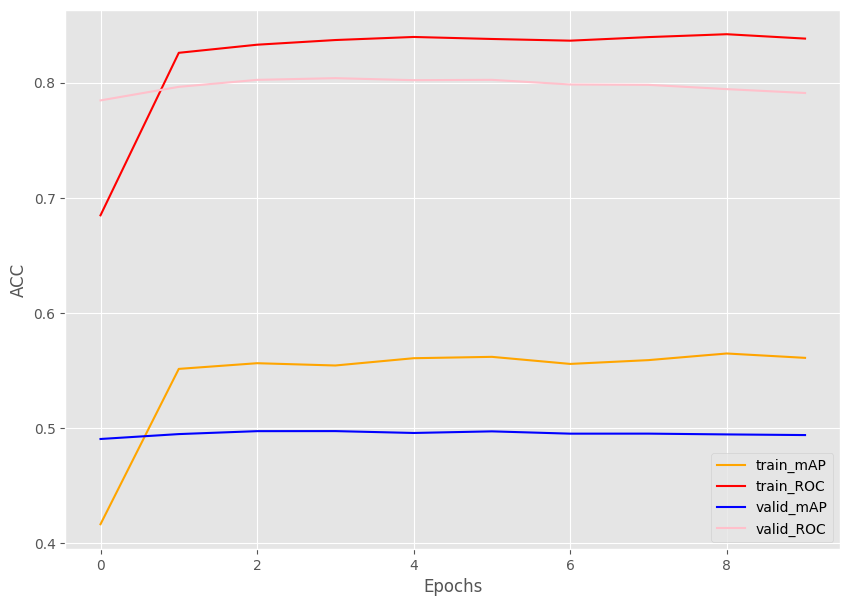

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_mAP, color='orange', label='train_mAP')
plt.plot(train_ROC, color='red', label='train_ROC')
plt.plot(valid_mAP, color='blue',label ='valid_mAP')
plt.plot(valid_ROC, color='pink', label='valid_ROC')
plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.legend()
plt.savefig('../ACC_rerun.png')
plt.show()

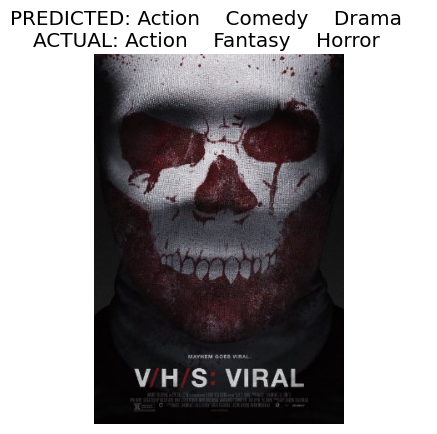

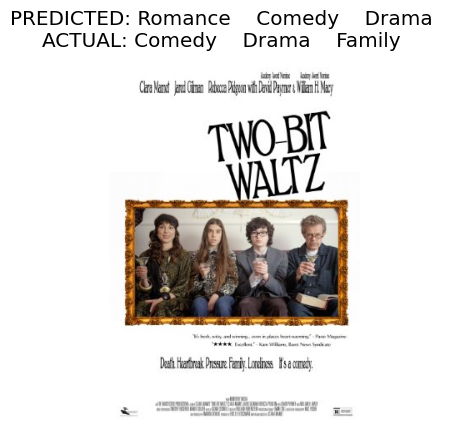

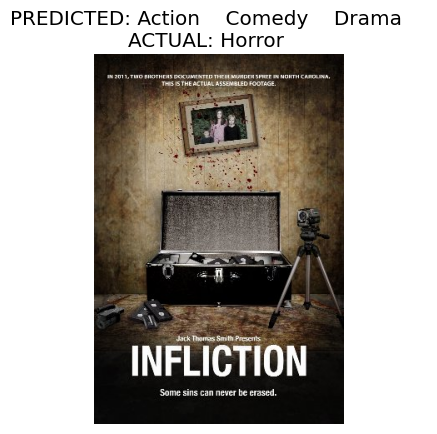

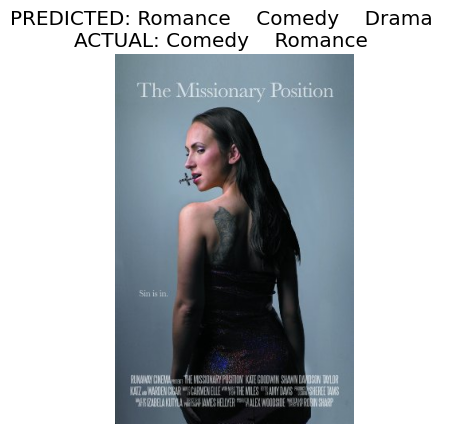

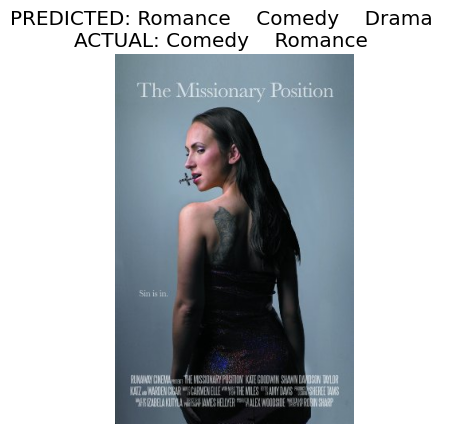

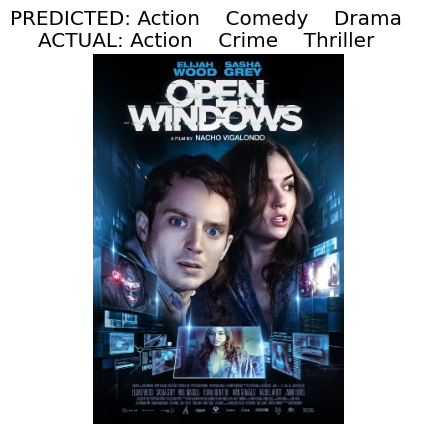

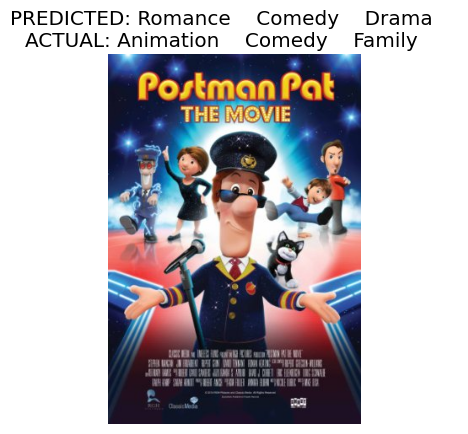

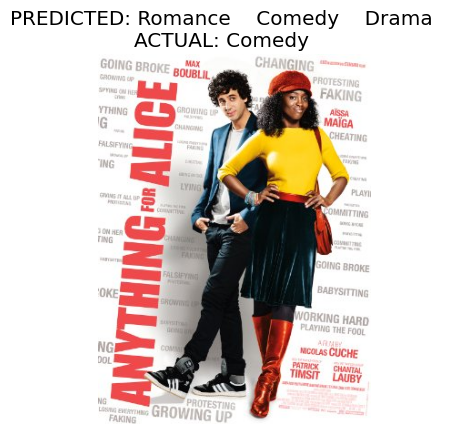

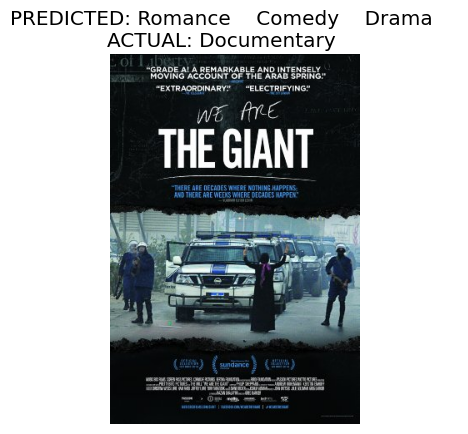

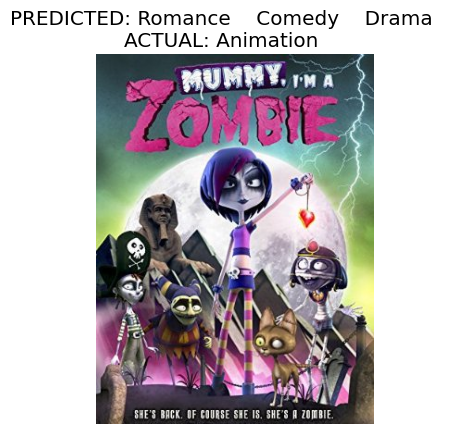

In [ ]:
train_csv = pd.read_csv('train.csv')
genres = train_csv.columns.values[2:]
# prepare the test dataset and dataloader
test_data = ImageDataset(
    train_csv, train=False, test=True
)
test_loader = DataLoader(
    test_data,
    batch_size=1,
    shuffle=False
)
all_preds = []
all_labels = []
for counter, data in enumerate(test_loader):
    image, target = data['image'].to(device), data['label'].to(device)
    # get all the index positions where value == 1
    target_indices = [i for i in range(len(target[0])) if target[0][i] == 1]
    # get the predictions by passing the image through the model
    outputs = model(image)
    outputs = torch.sigmoid(outputs)
    preds = (outputs > 0.5).float()
    outputs = outputs.detach().cpu()
    sorted_indices = np.argsort(outputs[0])
    best = sorted_indices[-3:]
    ########## included later ###############
    all_preds.append(preds.cpu().numpy())
    all_labels.append(target.cpu().numpy())
    #########################################
    string_predicted = ''
    string_actual = ''
    for i in range(len(best)):
        string_predicted += f"{genres[best[i]]}    "
    for i in range(len(target_indices)):
        string_actual += f"{genres[target_indices[i]]}    "
    image = image.squeeze(0)
    image = image.detach().cpu().numpy()
    image = np.transpose(image, (1, 2, 0))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"PREDICTED: {string_predicted}\nACTUAL: {string_actual}")
    plt.savefig(f"inference_{counter}.jpg")
    plt.show()


